# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [01:11, 2.56MB/s]                              
SVHN Testing Set: 64.3MB [00:24, 2.66MB/s]                            


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

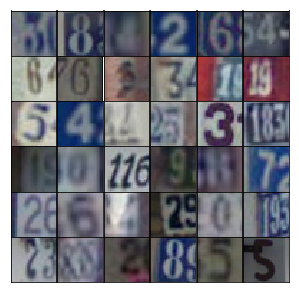

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [10]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        
        x1 = tf.layers.dense(z, 4*4*512)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [11]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [12]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [14]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [15]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [16]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [22]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 5
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/5... Discriminator Loss: 1.0649... Generator Loss: 0.8651
Epoch 1/5... Discriminator Loss: 0.4182... Generator Loss: 1.7211
Epoch 1/5... Discriminator Loss: 0.2057... Generator Loss: 2.1650
Epoch 1/5... Discriminator Loss: 0.1376... Generator Loss: 2.9132
Epoch 1/5... Discriminator Loss: 0.3244... Generator Loss: 1.8097
Epoch 1/5... Discriminator Loss: 0.1881... Generator Loss: 2.0689
Epoch 1/5... Discriminator Loss: 0.2263... Generator Loss: 2.2538
Epoch 1/5... Discriminator Loss: 0.2133... Generator Loss: 3.0104
Epoch 1/5... Discriminator Loss: 0.2097... Generator Loss: 2.7229
Epoch 1/5... Discriminator Loss: 0.3779... Generator Loss: 2.8799


/home/paperspace/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


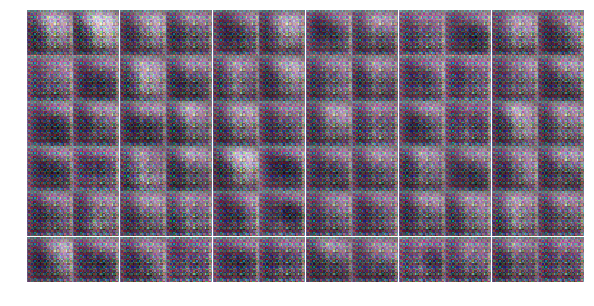

Epoch 1/5... Discriminator Loss: 0.4843... Generator Loss: 1.9015
Epoch 1/5... Discriminator Loss: 0.5107... Generator Loss: 1.4033
Epoch 1/5... Discriminator Loss: 0.4340... Generator Loss: 1.6089
Epoch 1/5... Discriminator Loss: 0.2407... Generator Loss: 3.1006
Epoch 1/5... Discriminator Loss: 0.4134... Generator Loss: 1.5396
Epoch 1/5... Discriminator Loss: 0.4023... Generator Loss: 1.9460
Epoch 1/5... Discriminator Loss: 0.4037... Generator Loss: 1.6697
Epoch 1/5... Discriminator Loss: 0.6620... Generator Loss: 2.5553
Epoch 1/5... Discriminator Loss: 1.1904... Generator Loss: 5.3881
Epoch 1/5... Discriminator Loss: 2.4317... Generator Loss: 6.9924


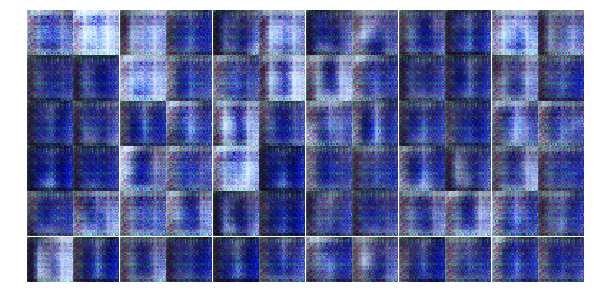

Epoch 1/5... Discriminator Loss: 1.6415... Generator Loss: 0.4583
Epoch 1/5... Discriminator Loss: 0.9005... Generator Loss: 0.8898
Epoch 1/5... Discriminator Loss: 1.1966... Generator Loss: 0.5527
Epoch 1/5... Discriminator Loss: 0.7714... Generator Loss: 2.6152
Epoch 1/5... Discriminator Loss: 0.1569... Generator Loss: 2.8365
Epoch 1/5... Discriminator Loss: 0.3193... Generator Loss: 4.0054
Epoch 1/5... Discriminator Loss: 1.2748... Generator Loss: 1.5610
Epoch 1/5... Discriminator Loss: 1.2146... Generator Loss: 0.9023
Epoch 1/5... Discriminator Loss: 0.6465... Generator Loss: 1.7114
Epoch 1/5... Discriminator Loss: 0.5177... Generator Loss: 1.9406


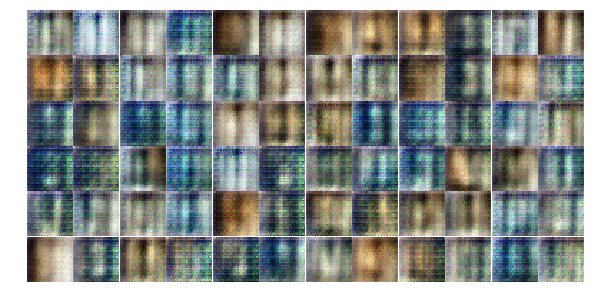

Epoch 1/5... Discriminator Loss: 0.7670... Generator Loss: 1.3880
Epoch 1/5... Discriminator Loss: 0.5261... Generator Loss: 1.3378
Epoch 1/5... Discriminator Loss: 0.6833... Generator Loss: 1.5844
Epoch 1/5... Discriminator Loss: 0.8807... Generator Loss: 1.0340
Epoch 1/5... Discriminator Loss: 0.6562... Generator Loss: 1.3802
Epoch 1/5... Discriminator Loss: 0.9037... Generator Loss: 0.9361
Epoch 1/5... Discriminator Loss: 0.9347... Generator Loss: 0.8390
Epoch 1/5... Discriminator Loss: 0.4561... Generator Loss: 2.1084
Epoch 1/5... Discriminator Loss: 0.4752... Generator Loss: 1.7099
Epoch 1/5... Discriminator Loss: 0.4752... Generator Loss: 2.0662


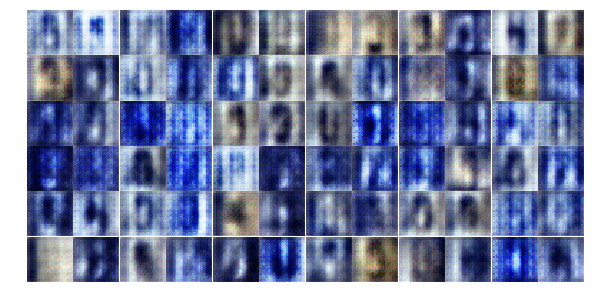

Epoch 1/5... Discriminator Loss: 0.7174... Generator Loss: 1.3373
Epoch 1/5... Discriminator Loss: 0.7617... Generator Loss: 1.7316
Epoch 1/5... Discriminator Loss: 1.0630... Generator Loss: 0.7499
Epoch 1/5... Discriminator Loss: 0.7556... Generator Loss: 1.7087
Epoch 1/5... Discriminator Loss: 0.9541... Generator Loss: 1.0576
Epoch 1/5... Discriminator Loss: 0.7111... Generator Loss: 1.9140
Epoch 1/5... Discriminator Loss: 0.7938... Generator Loss: 1.0758
Epoch 1/5... Discriminator Loss: 0.4770... Generator Loss: 1.9426
Epoch 1/5... Discriminator Loss: 0.6934... Generator Loss: 1.0950
Epoch 1/5... Discriminator Loss: 0.7455... Generator Loss: 1.5287


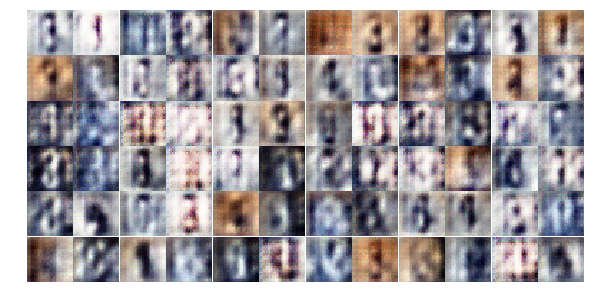

Epoch 1/5... Discriminator Loss: 1.0679... Generator Loss: 0.7697
Epoch 1/5... Discriminator Loss: 0.9525... Generator Loss: 1.6747
Epoch 1/5... Discriminator Loss: 0.7609... Generator Loss: 1.5832
Epoch 1/5... Discriminator Loss: 1.0695... Generator Loss: 0.7547
Epoch 1/5... Discriminator Loss: 0.8896... Generator Loss: 1.8575
Epoch 1/5... Discriminator Loss: 0.7231... Generator Loss: 1.2348
Epoch 1/5... Discriminator Loss: 0.7383... Generator Loss: 1.3456
Epoch 2/5... Discriminator Loss: 0.8477... Generator Loss: 1.3228
Epoch 2/5... Discriminator Loss: 0.7012... Generator Loss: 2.0486
Epoch 2/5... Discriminator Loss: 0.8432... Generator Loss: 1.0156


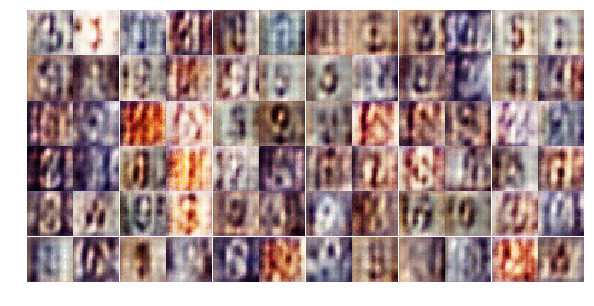

Epoch 2/5... Discriminator Loss: 0.8192... Generator Loss: 1.0529
Epoch 2/5... Discriminator Loss: 1.0232... Generator Loss: 0.8730
Epoch 2/5... Discriminator Loss: 1.4949... Generator Loss: 0.8588
Epoch 2/5... Discriminator Loss: 1.1924... Generator Loss: 0.8286
Epoch 2/5... Discriminator Loss: 0.9749... Generator Loss: 1.0047
Epoch 2/5... Discriminator Loss: 1.3927... Generator Loss: 0.5990
Epoch 2/5... Discriminator Loss: 0.8983... Generator Loss: 1.3333
Epoch 2/5... Discriminator Loss: 1.1058... Generator Loss: 0.8380
Epoch 2/5... Discriminator Loss: 0.6681... Generator Loss: 1.6515
Epoch 2/5... Discriminator Loss: 1.0894... Generator Loss: 1.1208


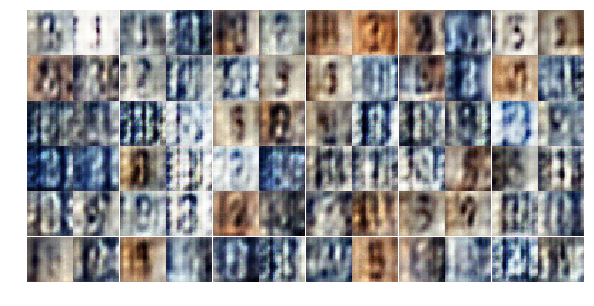

Epoch 2/5... Discriminator Loss: 1.0568... Generator Loss: 1.0951
Epoch 2/5... Discriminator Loss: 0.8854... Generator Loss: 0.9780
Epoch 2/5... Discriminator Loss: 0.8848... Generator Loss: 1.5014
Epoch 2/5... Discriminator Loss: 0.7933... Generator Loss: 1.3115
Epoch 2/5... Discriminator Loss: 0.9918... Generator Loss: 1.2695
Epoch 2/5... Discriminator Loss: 1.2022... Generator Loss: 1.0323
Epoch 2/5... Discriminator Loss: 0.9804... Generator Loss: 0.8121
Epoch 2/5... Discriminator Loss: 1.1169... Generator Loss: 0.8121
Epoch 2/5... Discriminator Loss: 1.1769... Generator Loss: 0.6664
Epoch 2/5... Discriminator Loss: 1.0025... Generator Loss: 0.6753


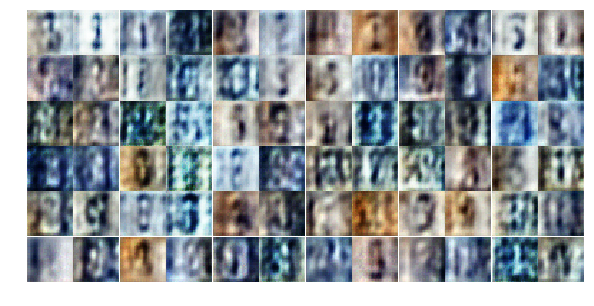

Epoch 2/5... Discriminator Loss: 0.9904... Generator Loss: 0.9671
Epoch 2/5... Discriminator Loss: 0.8875... Generator Loss: 1.2097
Epoch 2/5... Discriminator Loss: 0.7580... Generator Loss: 1.5103
Epoch 2/5... Discriminator Loss: 0.9479... Generator Loss: 1.7844
Epoch 2/5... Discriminator Loss: 0.9344... Generator Loss: 1.2556
Epoch 2/5... Discriminator Loss: 0.9506... Generator Loss: 1.2133
Epoch 2/5... Discriminator Loss: 1.0382... Generator Loss: 0.7335
Epoch 2/5... Discriminator Loss: 1.1326... Generator Loss: 0.7477
Epoch 2/5... Discriminator Loss: 1.1322... Generator Loss: 1.0352
Epoch 2/5... Discriminator Loss: 1.0668... Generator Loss: 0.7835


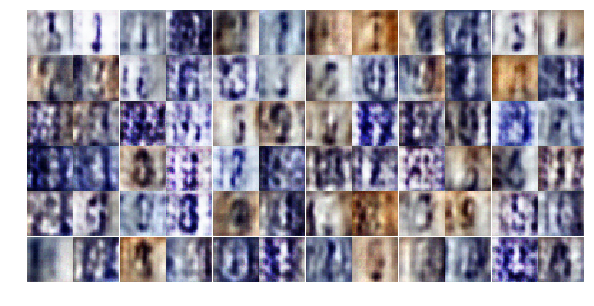

Epoch 2/5... Discriminator Loss: 0.9575... Generator Loss: 2.0423
Epoch 2/5... Discriminator Loss: 1.0652... Generator Loss: 1.3611
Epoch 2/5... Discriminator Loss: 1.1074... Generator Loss: 0.8657
Epoch 2/5... Discriminator Loss: 1.1960... Generator Loss: 0.6243
Epoch 2/5... Discriminator Loss: 1.0356... Generator Loss: 1.7656
Epoch 2/5... Discriminator Loss: 1.0995... Generator Loss: 0.8041
Epoch 2/5... Discriminator Loss: 1.3122... Generator Loss: 0.8068
Epoch 2/5... Discriminator Loss: 0.8700... Generator Loss: 1.6884
Epoch 2/5... Discriminator Loss: 1.1896... Generator Loss: 1.6439
Epoch 2/5... Discriminator Loss: 1.0512... Generator Loss: 0.8417


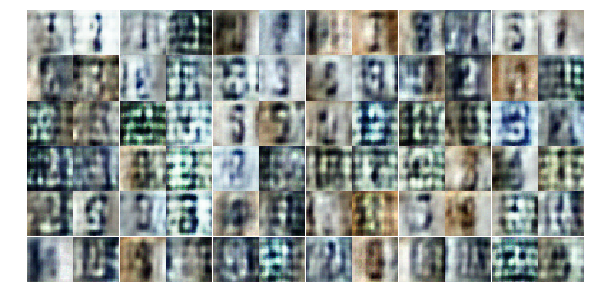

Epoch 2/5... Discriminator Loss: 0.6731... Generator Loss: 1.1958
Epoch 2/5... Discriminator Loss: 1.3481... Generator Loss: 0.7214
Epoch 2/5... Discriminator Loss: 0.7807... Generator Loss: 1.6207
Epoch 2/5... Discriminator Loss: 1.1056... Generator Loss: 0.7471
Epoch 2/5... Discriminator Loss: 0.8767... Generator Loss: 1.1028
Epoch 2/5... Discriminator Loss: 1.1645... Generator Loss: 0.5726
Epoch 2/5... Discriminator Loss: 0.7039... Generator Loss: 1.9019
Epoch 2/5... Discriminator Loss: 0.7610... Generator Loss: 1.1122
Epoch 2/5... Discriminator Loss: 0.6350... Generator Loss: 1.3568
Epoch 2/5... Discriminator Loss: 0.6724... Generator Loss: 1.7099


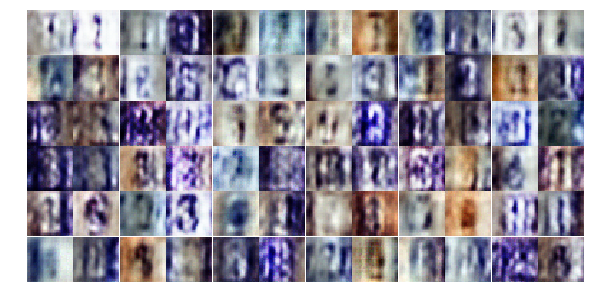

Epoch 2/5... Discriminator Loss: 0.8340... Generator Loss: 0.9017
Epoch 2/5... Discriminator Loss: 0.8675... Generator Loss: 1.1990
Epoch 2/5... Discriminator Loss: 1.0390... Generator Loss: 0.6461
Epoch 2/5... Discriminator Loss: 0.8336... Generator Loss: 1.1935
Epoch 3/5... Discriminator Loss: 0.4169... Generator Loss: 1.8746
Epoch 3/5... Discriminator Loss: 0.8050... Generator Loss: 1.4572
Epoch 3/5... Discriminator Loss: 0.6918... Generator Loss: 2.2499
Epoch 3/5... Discriminator Loss: 0.9882... Generator Loss: 0.6737
Epoch 3/5... Discriminator Loss: 1.1602... Generator Loss: 2.2730
Epoch 3/5... Discriminator Loss: 1.0868... Generator Loss: 0.6467


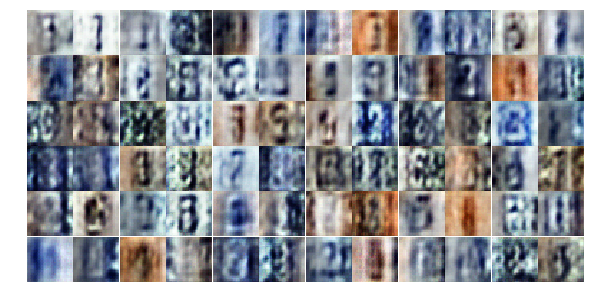

Epoch 3/5... Discriminator Loss: 0.7015... Generator Loss: 1.2942
Epoch 3/5... Discriminator Loss: 0.6528... Generator Loss: 1.1925
Epoch 3/5... Discriminator Loss: 0.5760... Generator Loss: 1.5660
Epoch 3/5... Discriminator Loss: 0.4721... Generator Loss: 1.6618
Epoch 3/5... Discriminator Loss: 0.7338... Generator Loss: 0.8781
Epoch 3/5... Discriminator Loss: 1.9514... Generator Loss: 4.3286
Epoch 3/5... Discriminator Loss: 0.7772... Generator Loss: 0.8729
Epoch 3/5... Discriminator Loss: 1.4060... Generator Loss: 0.7751
Epoch 3/5... Discriminator Loss: 0.7115... Generator Loss: 1.2425
Epoch 3/5... Discriminator Loss: 1.0373... Generator Loss: 0.8769


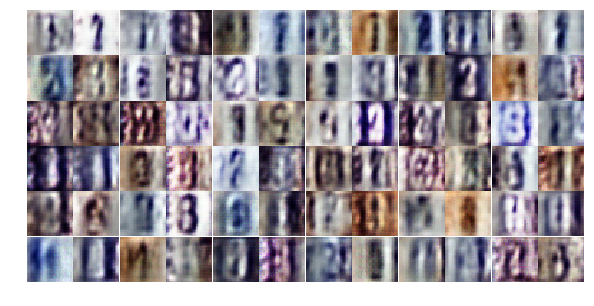

Epoch 3/5... Discriminator Loss: 0.6773... Generator Loss: 1.2792
Epoch 3/5... Discriminator Loss: 0.5853... Generator Loss: 1.4505
Epoch 3/5... Discriminator Loss: 1.3327... Generator Loss: 1.8266
Epoch 3/5... Discriminator Loss: 0.6280... Generator Loss: 1.4855
Epoch 3/5... Discriminator Loss: 0.5174... Generator Loss: 1.6457
Epoch 3/5... Discriminator Loss: 0.6035... Generator Loss: 1.8429
Epoch 3/5... Discriminator Loss: 0.4710... Generator Loss: 1.4030
Epoch 3/5... Discriminator Loss: 0.4157... Generator Loss: 2.2607
Epoch 3/5... Discriminator Loss: 0.5909... Generator Loss: 1.2590
Epoch 3/5... Discriminator Loss: 0.4920... Generator Loss: 1.4988


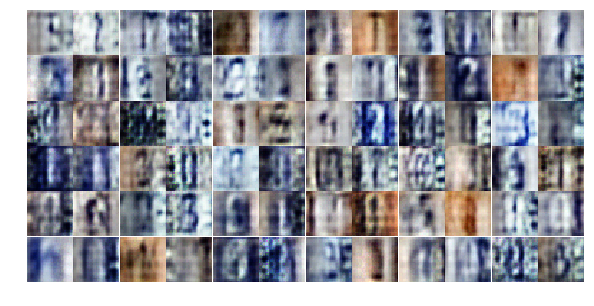

Epoch 3/5... Discriminator Loss: 0.5406... Generator Loss: 2.3516
Epoch 3/5... Discriminator Loss: 0.8442... Generator Loss: 0.9960
Epoch 3/5... Discriminator Loss: 0.7197... Generator Loss: 1.5653
Epoch 3/5... Discriminator Loss: 0.6973... Generator Loss: 1.4090
Epoch 3/5... Discriminator Loss: 0.5404... Generator Loss: 1.4891
Epoch 3/5... Discriminator Loss: 0.5781... Generator Loss: 1.4872
Epoch 3/5... Discriminator Loss: 0.5118... Generator Loss: 1.4736
Epoch 3/5... Discriminator Loss: 0.4867... Generator Loss: 1.6391
Epoch 3/5... Discriminator Loss: 0.4619... Generator Loss: 1.5089
Epoch 3/5... Discriminator Loss: 0.8640... Generator Loss: 0.8424


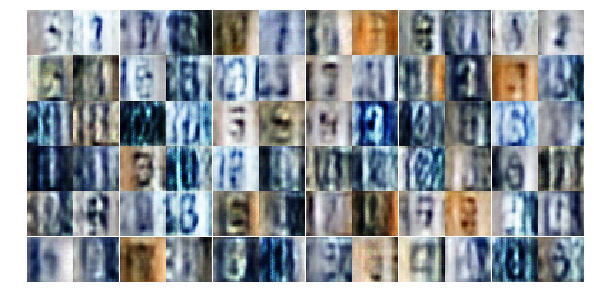

Epoch 3/5... Discriminator Loss: 0.8102... Generator Loss: 1.0136
Epoch 3/5... Discriminator Loss: 0.2661... Generator Loss: 2.8038
Epoch 3/5... Discriminator Loss: 0.5569... Generator Loss: 1.6227
Epoch 3/5... Discriminator Loss: 0.7528... Generator Loss: 1.2013
Epoch 3/5... Discriminator Loss: 0.6629... Generator Loss: 2.2812
Epoch 3/5... Discriminator Loss: 0.9340... Generator Loss: 0.8051
Epoch 3/5... Discriminator Loss: 0.6355... Generator Loss: 1.4924
Epoch 3/5... Discriminator Loss: 0.4284... Generator Loss: 1.7759
Epoch 3/5... Discriminator Loss: 0.5809... Generator Loss: 1.3430
Epoch 3/5... Discriminator Loss: 0.6456... Generator Loss: 1.1605


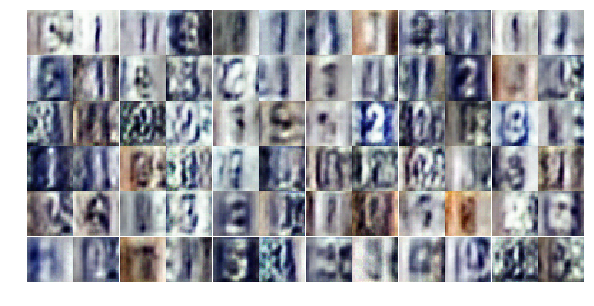

Epoch 3/5... Discriminator Loss: 1.2727... Generator Loss: 0.5232
Epoch 3/5... Discriminator Loss: 0.5224... Generator Loss: 1.2859
Epoch 3/5... Discriminator Loss: 0.5960... Generator Loss: 1.3696
Epoch 3/5... Discriminator Loss: 0.7383... Generator Loss: 0.9570
Epoch 3/5... Discriminator Loss: 0.6135... Generator Loss: 1.9081
Epoch 3/5... Discriminator Loss: 0.6869... Generator Loss: 1.0343
Epoch 3/5... Discriminator Loss: 0.7022... Generator Loss: 2.4170
Epoch 3/5... Discriminator Loss: 0.4947... Generator Loss: 2.0532
Epoch 3/5... Discriminator Loss: 0.5665... Generator Loss: 1.2141
Epoch 3/5... Discriminator Loss: 0.9840... Generator Loss: 1.1492


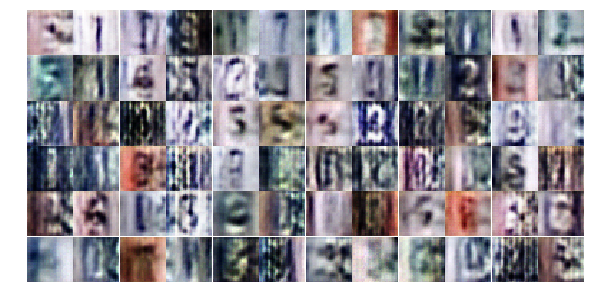

Epoch 3/5... Discriminator Loss: 1.5440... Generator Loss: 0.3338
Epoch 4/5... Discriminator Loss: 0.9405... Generator Loss: 1.7673
Epoch 4/5... Discriminator Loss: 0.5579... Generator Loss: 1.7326
Epoch 4/5... Discriminator Loss: 1.3312... Generator Loss: 0.4365
Epoch 4/5... Discriminator Loss: 0.5249... Generator Loss: 1.7992
Epoch 4/5... Discriminator Loss: 0.4905... Generator Loss: 1.4259
Epoch 4/5... Discriminator Loss: 0.5641... Generator Loss: 1.4724
Epoch 4/5... Discriminator Loss: 0.6523... Generator Loss: 1.1342
Epoch 4/5... Discriminator Loss: 0.7424... Generator Loss: 0.8330
Epoch 4/5... Discriminator Loss: 0.5687... Generator Loss: 1.2531


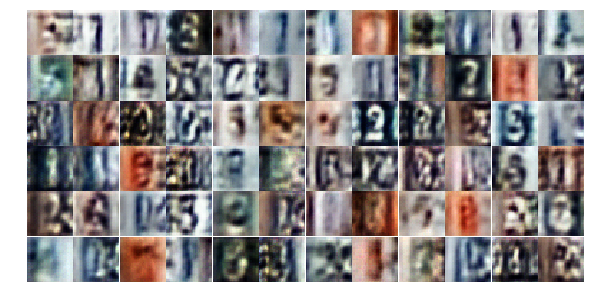

Epoch 4/5... Discriminator Loss: 0.6203... Generator Loss: 1.3629
Epoch 4/5... Discriminator Loss: 1.4538... Generator Loss: 2.1015
Epoch 4/5... Discriminator Loss: 1.0388... Generator Loss: 0.7830
Epoch 4/5... Discriminator Loss: 0.5395... Generator Loss: 1.3731
Epoch 4/5... Discriminator Loss: 0.6795... Generator Loss: 1.2933
Epoch 4/5... Discriminator Loss: 1.2310... Generator Loss: 0.4636
Epoch 4/5... Discriminator Loss: 0.7244... Generator Loss: 0.9514
Epoch 4/5... Discriminator Loss: 0.6874... Generator Loss: 0.9853
Epoch 4/5... Discriminator Loss: 0.5684... Generator Loss: 2.0470
Epoch 4/5... Discriminator Loss: 0.9348... Generator Loss: 2.8955


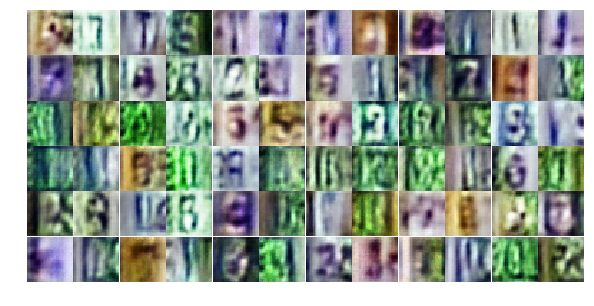

Epoch 4/5... Discriminator Loss: 0.9090... Generator Loss: 1.0012
Epoch 4/5... Discriminator Loss: 0.6337... Generator Loss: 2.1131
Epoch 4/5... Discriminator Loss: 0.5511... Generator Loss: 1.6171
Epoch 4/5... Discriminator Loss: 0.6021... Generator Loss: 1.1876
Epoch 4/5... Discriminator Loss: 0.3342... Generator Loss: 2.0155
Epoch 4/5... Discriminator Loss: 0.5933... Generator Loss: 2.7908
Epoch 4/5... Discriminator Loss: 0.5850... Generator Loss: 1.1554
Epoch 4/5... Discriminator Loss: 0.4557... Generator Loss: 1.5094
Epoch 4/5... Discriminator Loss: 0.5271... Generator Loss: 2.4231
Epoch 4/5... Discriminator Loss: 0.5409... Generator Loss: 1.2859


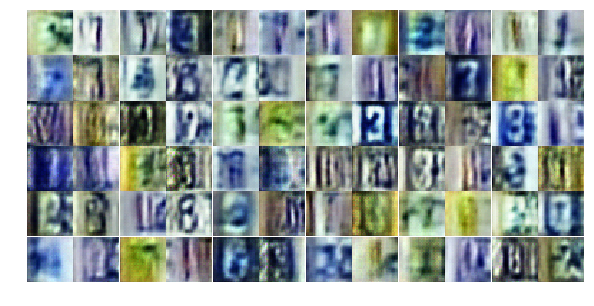

Epoch 4/5... Discriminator Loss: 0.5789... Generator Loss: 1.1460
Epoch 4/5... Discriminator Loss: 0.6197... Generator Loss: 1.2429
Epoch 4/5... Discriminator Loss: 0.4690... Generator Loss: 1.4938
Epoch 4/5... Discriminator Loss: 0.4559... Generator Loss: 1.7864
Epoch 4/5... Discriminator Loss: 0.6044... Generator Loss: 1.8054
Epoch 4/5... Discriminator Loss: 0.5861... Generator Loss: 1.2876
Epoch 4/5... Discriminator Loss: 1.1911... Generator Loss: 2.9608
Epoch 4/5... Discriminator Loss: 0.8841... Generator Loss: 1.6287
Epoch 4/5... Discriminator Loss: 0.5577... Generator Loss: 1.3631
Epoch 4/5... Discriminator Loss: 0.6903... Generator Loss: 1.6857


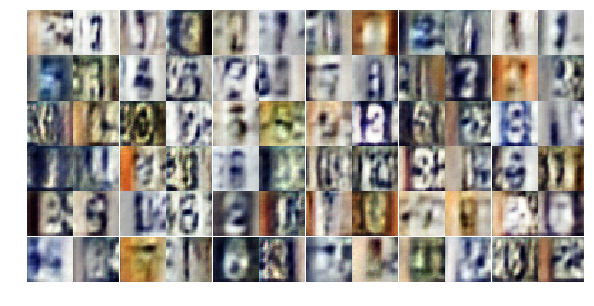

Epoch 4/5... Discriminator Loss: 0.4954... Generator Loss: 1.2805
Epoch 4/5... Discriminator Loss: 0.5290... Generator Loss: 1.3405
Epoch 4/5... Discriminator Loss: 0.4410... Generator Loss: 1.5351
Epoch 4/5... Discriminator Loss: 0.4447... Generator Loss: 1.6968
Epoch 4/5... Discriminator Loss: 0.4748... Generator Loss: 1.7535
Epoch 4/5... Discriminator Loss: 0.7074... Generator Loss: 1.0849
Epoch 4/5... Discriminator Loss: 0.9664... Generator Loss: 0.7857
Epoch 4/5... Discriminator Loss: 0.4608... Generator Loss: 2.2219
Epoch 4/5... Discriminator Loss: 0.7115... Generator Loss: 0.9850
Epoch 4/5... Discriminator Loss: 0.5322... Generator Loss: 1.3290


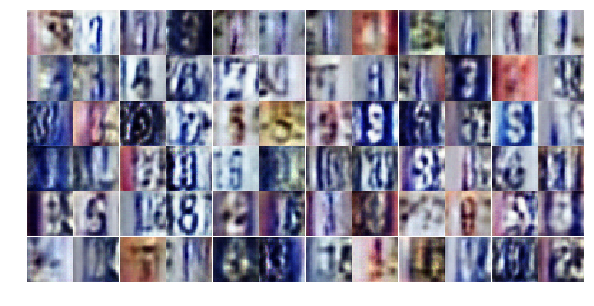

Epoch 4/5... Discriminator Loss: 0.4462... Generator Loss: 2.2337
Epoch 4/5... Discriminator Loss: 0.3829... Generator Loss: 1.9019
Epoch 4/5... Discriminator Loss: 0.4157... Generator Loss: 1.6489
Epoch 4/5... Discriminator Loss: 0.7498... Generator Loss: 1.1057
Epoch 4/5... Discriminator Loss: 0.5370... Generator Loss: 2.2182
Epoch 4/5... Discriminator Loss: 0.9888... Generator Loss: 2.5637
Epoch 4/5... Discriminator Loss: 0.5642... Generator Loss: 1.1337
Epoch 4/5... Discriminator Loss: 0.5857... Generator Loss: 1.2679
Epoch 4/5... Discriminator Loss: 0.4666... Generator Loss: 1.8196
Epoch 5/5... Discriminator Loss: 0.5669... Generator Loss: 1.0678


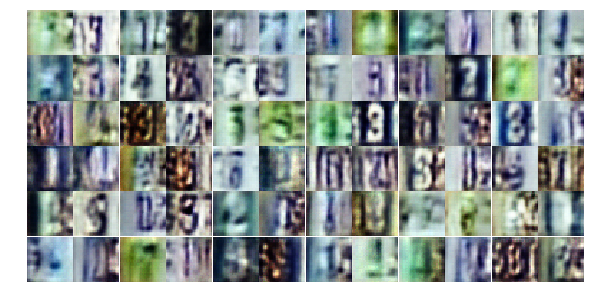

Epoch 5/5... Discriminator Loss: 0.3045... Generator Loss: 2.0528
Epoch 5/5... Discriminator Loss: 0.4814... Generator Loss: 1.6590
Epoch 5/5... Discriminator Loss: 0.5187... Generator Loss: 1.3510
Epoch 5/5... Discriminator Loss: 0.9062... Generator Loss: 0.6958
Epoch 5/5... Discriminator Loss: 0.5397... Generator Loss: 1.4701
Epoch 5/5... Discriminator Loss: 0.9193... Generator Loss: 0.7336
Epoch 5/5... Discriminator Loss: 0.3721... Generator Loss: 1.8679
Epoch 5/5... Discriminator Loss: 0.4546... Generator Loss: 1.4217
Epoch 5/5... Discriminator Loss: 0.7936... Generator Loss: 1.4463
Epoch 5/5... Discriminator Loss: 0.6521... Generator Loss: 1.4131


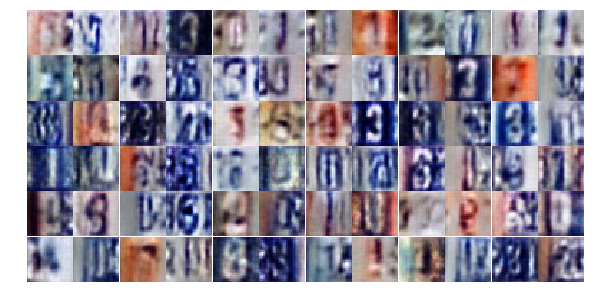

Epoch 5/5... Discriminator Loss: 1.0979... Generator Loss: 1.8590
Epoch 5/5... Discriminator Loss: 0.5575... Generator Loss: 1.1716
Epoch 5/5... Discriminator Loss: 0.4094... Generator Loss: 1.7314
Epoch 5/5... Discriminator Loss: 1.8862... Generator Loss: 2.7775
Epoch 5/5... Discriminator Loss: 1.0501... Generator Loss: 0.6827
Epoch 5/5... Discriminator Loss: 0.8123... Generator Loss: 0.9784
Epoch 5/5... Discriminator Loss: 0.6009... Generator Loss: 1.1765
Epoch 5/5... Discriminator Loss: 0.6514... Generator Loss: 1.6932
Epoch 5/5... Discriminator Loss: 0.4898... Generator Loss: 2.0901
Epoch 5/5... Discriminator Loss: 0.4740... Generator Loss: 1.7778


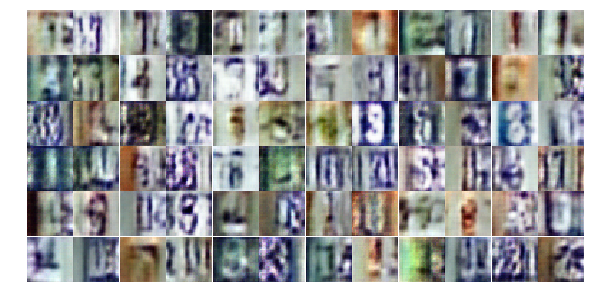

Epoch 5/5... Discriminator Loss: 0.7237... Generator Loss: 0.9442
Epoch 5/5... Discriminator Loss: 0.6183... Generator Loss: 1.4897
Epoch 5/5... Discriminator Loss: 0.5982... Generator Loss: 1.4424
Epoch 5/5... Discriminator Loss: 0.5216... Generator Loss: 1.2729
Epoch 5/5... Discriminator Loss: 0.7990... Generator Loss: 0.8483
Epoch 5/5... Discriminator Loss: 0.6605... Generator Loss: 0.9738
Epoch 5/5... Discriminator Loss: 1.2585... Generator Loss: 0.4318
Epoch 5/5... Discriminator Loss: 0.6275... Generator Loss: 1.2416
Epoch 5/5... Discriminator Loss: 1.1874... Generator Loss: 0.5219
Epoch 5/5... Discriminator Loss: 0.5012... Generator Loss: 1.9495


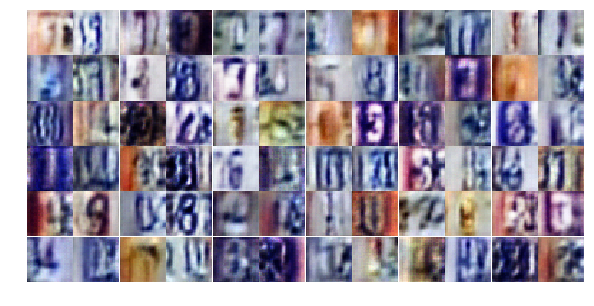

Epoch 5/5... Discriminator Loss: 0.6584... Generator Loss: 1.4555
Epoch 5/5... Discriminator Loss: 0.4788... Generator Loss: 1.3101
Epoch 5/5... Discriminator Loss: 0.7685... Generator Loss: 0.8726
Epoch 5/5... Discriminator Loss: 0.6576... Generator Loss: 1.0100
Epoch 5/5... Discriminator Loss: 0.5875... Generator Loss: 1.6488
Epoch 5/5... Discriminator Loss: 0.6707... Generator Loss: 1.6438
Epoch 5/5... Discriminator Loss: 1.6165... Generator Loss: 0.2798
Epoch 5/5... Discriminator Loss: 0.4868... Generator Loss: 1.3235
Epoch 5/5... Discriminator Loss: 1.3166... Generator Loss: 0.4157
Epoch 5/5... Discriminator Loss: 0.6365... Generator Loss: 1.2834


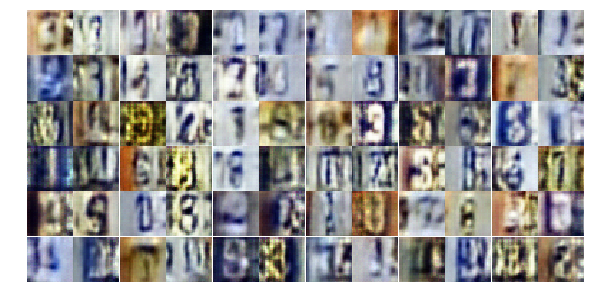

Epoch 5/5... Discriminator Loss: 0.4842... Generator Loss: 1.6232
Epoch 5/5... Discriminator Loss: 0.8003... Generator Loss: 0.7689
Epoch 5/5... Discriminator Loss: 1.2159... Generator Loss: 0.5068
Epoch 5/5... Discriminator Loss: 0.5454... Generator Loss: 1.7897
Epoch 5/5... Discriminator Loss: 3.2096... Generator Loss: 5.3400
Epoch 5/5... Discriminator Loss: 0.9212... Generator Loss: 0.7745
Epoch 5/5... Discriminator Loss: 0.7242... Generator Loss: 1.3105
Epoch 5/5... Discriminator Loss: 0.7275... Generator Loss: 1.0532
Epoch 5/5... Discriminator Loss: 0.5578... Generator Loss: 2.0291
Epoch 5/5... Discriminator Loss: 0.5633... Generator Loss: 1.6355


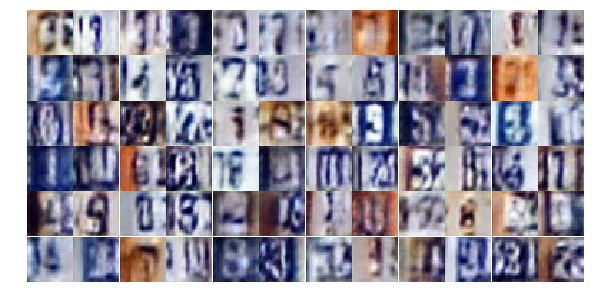

Epoch 5/5... Discriminator Loss: 0.8093... Generator Loss: 3.4161
Epoch 5/5... Discriminator Loss: 1.1022... Generator Loss: 0.5559
Epoch 5/5... Discriminator Loss: 0.7814... Generator Loss: 0.8837
Epoch 5/5... Discriminator Loss: 0.6950... Generator Loss: 1.0000
Epoch 5/5... Discriminator Loss: 0.5355... Generator Loss: 1.2926
Epoch 5/5... Discriminator Loss: 0.8209... Generator Loss: 0.8569


In [23]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

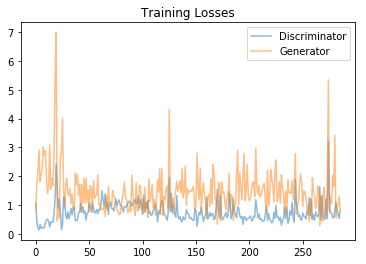

In [24]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

/home/paperspace/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


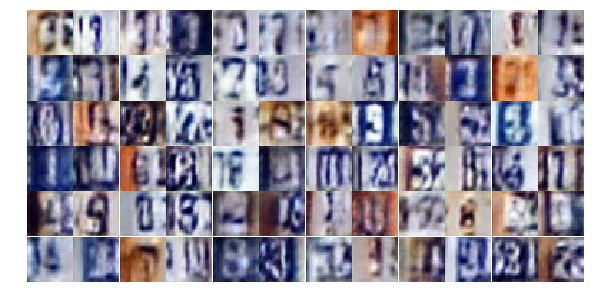

In [25]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))